In [7]:
from SimPEG import Mesh, Utils, Maps, Survey
from SimPEG.EM.Static import DC, IP
from pymatsolver import MumpsSolver
from ipywidgets import interact, IntSlider
import sys
sys.path.append("../utilcodes/")
from vizutils import viz, gettopoCC, vizEJ
%pylab inline
import matplotlib
matplotlib.rcParams['font.size'] = 14

Populating the interactive namespace from numpy and matplotlib


# DC example

## Mesh and Conductivity model

In [8]:
csx, csy, csz = 25., 25., 25.
ncx, ncy, ncz = 48, 48, 20
npad = 7
hx = [(csx,npad, -1.3),(csx,ncx),(csx,npad, 1.3)]
hy = [(csy,npad, -1.3),(csy,ncy),(csy,npad, 1.3)]
hz = [(csz,npad, -1.3),(csz,ncz), (csz/2.,6)]
mesh = Mesh.TensorMesh([hx, hy, hz],x0="CCN")
sigma = mesh.readModelUBC("VTKout_DC.dat")
airind = sigma == 1e-8

In [1]:
!pwd

/Users/sgkang/Projects/simpeg/presentations/SciPy2016/notebooks/DC


In [9]:
print mesh.vectorCCz.shape

(33,)


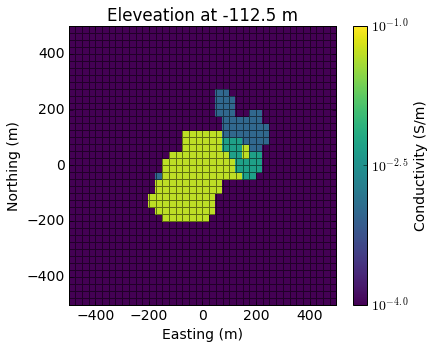

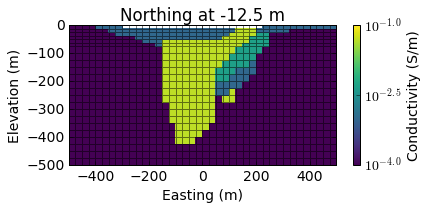

In [10]:
viz(mesh, sigma, 26, airind, normal="Z")
viz(mesh, sigma, 30, airind, normal="Y")

## Obtain topographic surface from 3D conductivity model

In [11]:
mesh2D, topoCC = gettopoCC(mesh, airind)

## Gradient array for DC survey

<img src="http://www.3ptscience.com/img/dc-survey" width=300></img>

In [12]:
Aloc1_x = np.r_[-600., 0, 0.]
Bloc1_x = np.r_[600., 0, 0.]
# Aloc2_x = np.r_[-350., 0, 0.]
# Bloc2_x = np.r_[350., 0, 0.]
# Aloc1_y = np.r_[0, -600., 0.]
# Bloc1_y = np.r_[0, 600. , 0.]
# Aloc2_y = np.r_[0, -350., 0.]
# Bloc2_y = np.r_[0, 350. , 0.]

In [16]:
x = mesh.vectorCCx[np.logical_and(mesh.vectorCCx>-300., mesh.vectorCCx<300.)]
y = mesh.vectorCCy[np.logical_and(mesh.vectorCCy>-300., mesh.vectorCCy<300.)]
Mx = Utils.ndgrid(x[:-1], y, np.r_[-12.5/2.])
Nx = Utils.ndgrid(x[1:], y, np.r_[-12.5/2.])
My = Utils.ndgrid(x, y[:-1], np.r_[-12.5/2.])
Ny = Utils.ndgrid(x, y[1:], np.r_[-12.5/2.])

In [17]:
inds_Mx = Utils.closestPoints(mesh2D, Mx[:,:2])
inds_Nx = Utils.closestPoints(mesh2D, Nx[:,:2])
inds_My = Utils.closestPoints(mesh2D, My[:,:2])
inds_Ny = Utils.closestPoints(mesh2D, Ny[:,:2])

In [18]:
Mx_dr = np.c_[Mx[:,0], Mx[:,1], topoCC[inds_Mx]]
Nx_dr = np.c_[Nx[:,0], Nx[:,1], topoCC[inds_Nx]]
My_dr = np.c_[My[:,0], My[:,1], topoCC[inds_My]]
Ny_dr = np.c_[Ny[:,0], Ny[:,1], topoCC[inds_Ny]]

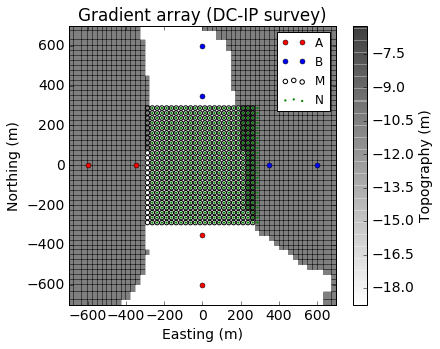

In [20]:
fig, ax = plt.subplots(1,1, figsize=(5*1.2,5))
dat = mesh2D.plotImage(topoCC,pcolorOpts={"cmap":"binary",'alpha':0.5}, ax=ax)
plt.xlabel("Easting (m)"); plt.ylabel("Northing (m)")
cb = plt.colorbar(dat[0]); cb.set_label("Topography (m)")
xlim(-500, 500)
ylim(-500, 500)

ax.plot(Aloc1_x[0], Aloc1_x[1], 'ro', ms=5)
ax.plot(Bloc1_x[0], Bloc1_x[1], 'bo', ms=5)
ax.scatter(Mx[:,0], Mx[:,1],s=20, edgecolors="k", facecolors="none")
ax.scatter(Nx[:,0], Nx[:,1],s=5, edgecolors="none", facecolors="g")
ax.legend(("A", "B", "M", "N"), fontsize=12)

ax.plot(Aloc2_x[0], Aloc2_x[1], 'ro', ms=5)
ax.plot(Bloc2_x[0], Bloc2_x[1], 'bo', ms=5)
ax.plot(Aloc1_y[0], Aloc1_y[1], 'ro', ms=5)
ax.plot(Bloc1_y[0], Bloc1_y[1], 'bo', ms=5)
ax.plot(Aloc2_y[0], Aloc2_y[1], 'ro', ms=5)
ax.plot(Bloc2_y[0], Bloc2_y[1], 'bo', ms=5)

ax.set_xlim(-700, 700)
ax.set_ylim(-700, 700)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")  
ax.set_title("Gradient array (DC-IP survey)")

In [21]:
# Src and Rx classes for DC problem
rx_x = DC.Rx.Dipole(Mx_dr, Nx_dr)
rx_y = DC.Rx.Dipole(My_dr, Ny_dr)
src1 = DC.Src.Dipole([rx_x, rx_y], Aloc1_x, Bloc1_x)
# src2 = DC.Src.Dipole([rx_x, rx_y], Aloc2_x, Bloc2_x)
# src3 = DC.Src.Dipole([rx_x, rx_y], Aloc1_y, Bloc1_y)
# src4 = DC.Src.Dipole([rx_x, rx_y], Aloc2_y, Bloc2_y)

In [22]:
# Inversion model is log conductivity in the subsurface
# This can be realized as a following mapping:
expmap = Maps.ExpMap(mesh) # from log conductivity to conductivity
actmap = Maps.InjectActiveCells(mesh, ~airind, np.log(1e-8)) # from subsurface cells to full3D cells
mapping = expmap*actmap

In [23]:
# Inital and reference model
m0 = np.ones_like(sigma)[~airind]*np.log(1e-4)

In [24]:
%%time
# Form survey object using Srcs and Rxs that we have generated
survey = DC.Survey([src1, src2, src3, src4])
problem = DC.Problem3D_CC(mesh, mapping=mapping)
problem.Solver = MumpsSolver
problem.pair(survey)
mtrue = np.log(sigma)[~airind]
f = problem.fields(mtrue)
# Run fwd
dobs = survey.dpred(mtrue, f=f)

CPU times: user 12.9 s, sys: 1.03 s, total: 14 s
Wall time: 11.4 s


In [25]:
dcdata = Survey.Data(survey, v=dobs)
Xx = 0.5*(Mx[:,0]+Nx[:,0]).reshape((23, 24), order="F")
Yx = Mx[:,1].reshape((23, 24), order="F")
Xy = My[:,0].reshape((24, 23), order="F")
Yy = 0.5*(My[:,1]+Ny[:,1]).reshape((24, 23), order="F")

<function __main__.<lambda>>

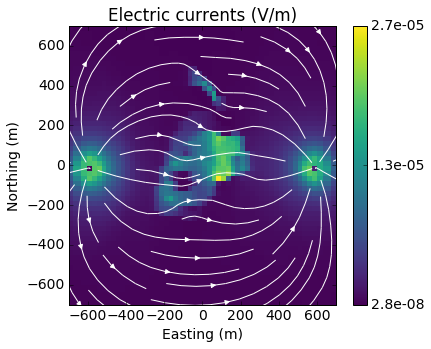

In [26]:
interact(lambda ind: vizEJ(mesh, sigma, ind, f=f, airind=airind, src=src1, normal="Z", ftype="J"), ind=IntSlider(min=0, max=32,step=1, value=28))

In [27]:
print mesh.vectorCCz[28]

-56.25


<function __main__.<lambda>>

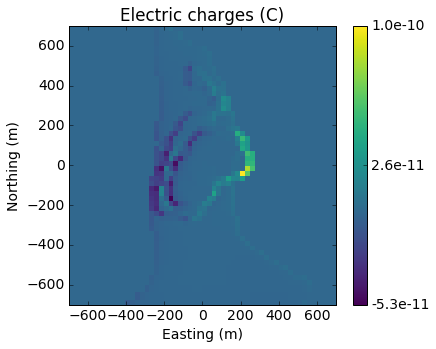

In [28]:

interact(lambda ind: vizEJ(mesh, sigma, ind, f=f, airind=airind, src=src1, normal="Z", ftype="charg"), ind=IntSlider(min=0, max=32,step=1, value=28))

<function __main__.<lambda>>

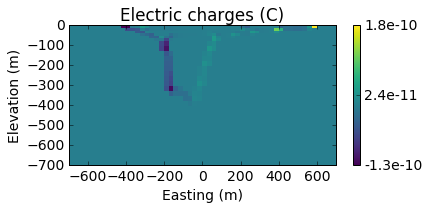

In [29]:
interact(lambda ind: vizEJ(mesh, sigma, ind, f=f, airind=airind, src=src1, normal="Y", ftype="charg"), ind=IntSlider(min=0, max=32,step=1, value=25))

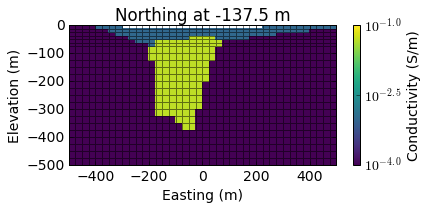

In [30]:
viz(mesh, sigma, 25, airind, normal="Y")

<function __main__.<lambda>>

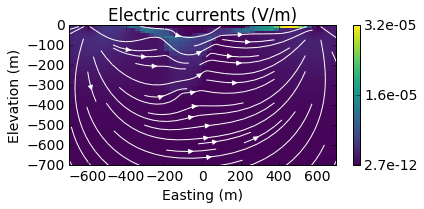

In [31]:
interact(lambda ind: vizEJ(mesh, sigma, ind, f=f, airind=airind, src=src1, normal="Y", ftype="J"), ind=IntSlider(min=0, max=32,step=1, value=25))

In [32]:
def vizdata(data, src, rx, rxcomponent="X", clim=None, title=None, figsave=None, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(6.8, 5.5))
        ax = plt.subplot(111)

    temp = data[src, rx]
    if rxcomponent=="X":
        X = Xx.copy()
        Y = Yx.copy()
    else:
        X = Xy.copy()
        Y = Yy.copy()
    temp = temp.reshape(X.shape, order="F")
    if clim is not None:
        vmin, vmax = clim[0], clim[1]
        dat = ax.contourf(X, Y, temp, 20, clim=clim, vmin=vmin, vmax=vmax, cmap="viridis")
        ax.contour(X, Y, temp, 10, colors="k")
    else:
        vmin, vmax = temp.min(), temp.max()
        dat = ax.contourf(X, Y, temp, 20, cmap="viridis")
        ax.contour(X, Y, temp, 10, colors="k")
        
    if title is not None:
        ax.set_title(title)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.axis("equal")

    cb = plt.colorbar(dat, ticks=np.linspace(vmin, vmax, 3), format="%.1e")
    cb.set_label("Potential (V)")
    if figsave is not None:
        fig.savefig(figsave, dpi=200)
    

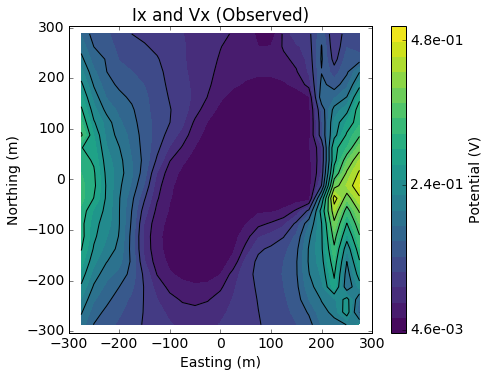

In [33]:
vizdata(dcdata, src1, rx_x, rxcomponent="X", title="Ix and Vx (Observed)", figsave="./images/IxVx_obs.png")

In [2]:
# vizdata(dcdata, src3, rx_y, rxcomponent="Y", title="Iy and Vy (Observed)", figsave="./images/IyVy_obs.png")

(-300, 300)

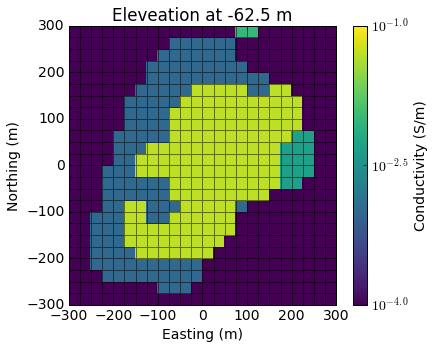

In [35]:
ax = viz(mesh, sigma, 28, airind, normal="Z")
ax.set_xlim(-300, 300)
ax.set_ylim(-300, 300)

In [3]:
# vizdata(dcdata, src1, rx_y, rxcomponent="Y")

In [4]:
# vizdata(dcdata, src3, rx_x, rxcomponent="Y")

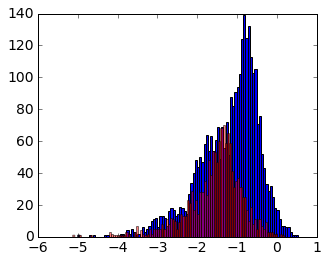

In [38]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
a = ax.hist(np.log10(dobs[dobs>0.]), bins=100)
b = ax.hist(np.log10(-dobs[dobs<0.]), bins=100, color='r', alpha=0.5)

In [39]:
depth = 1./(abs(mesh.gridCC[:,2]))**1.5
depth = depth/depth.max()

(-600, 0.0)

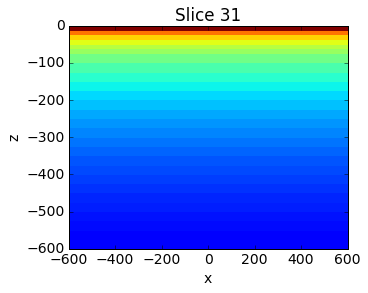

In [40]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
mesh.plotSlice(np.log10(depth), normal="Y", streamOpts={'color':'w'}, ax=ax)
ax.set_xlim(-600, 600)
ax.set_ylim(-600, 0.)    

In [41]:
from SimPEG import DataMisfit, Regularization, Optimization, Directives, InvProblem, Inversion
regmap = Maps.IdentityMap(nP=m0.size)
std = 0.05
eps = 1e-3
survey.std = std
survey.eps = eps
#TODO put warning when dobs is not set!
survey.dobs = dobs
dmisfit = DataMisfit.l2_DataMisfit(survey)
reg = Regularization.Simple(mesh, mapping=regmap, indActive=~airind)
reg.wght = depth[~airind]
opt = Optimization.InexactGaussNewton(maxIter = 20)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
# Create an inversion object
beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=2)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
save = Directives.SaveOutputEveryIteration()
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest, save, target])
reg.alpha_s = 1e-4
reg.alpha_x = 1.
reg.alpha_y = 1.
reg.alpha_z = 1.
problem.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)
sigopt = mapping*mopt
np.save("sigest", sigopt)

In [42]:
sigopt = np.load("sigest.npy")
# sigopt = mapping*mopt
dpred = survey.dpred(np.log(sigopt[~airind]))

In [43]:
from SimPEG import Survey
# datapred = invProb.dpred
obsdata = Survey.Data(survey, v=dobs)
preddata = Survey.Data(survey, v=dpred)

In [44]:
# figsize(8,3)
# plt.plot(obsdata[src1, rx_y])
# plt.plot(preddata[src1, rx_y], '.')

<function __main__.<lambda>>

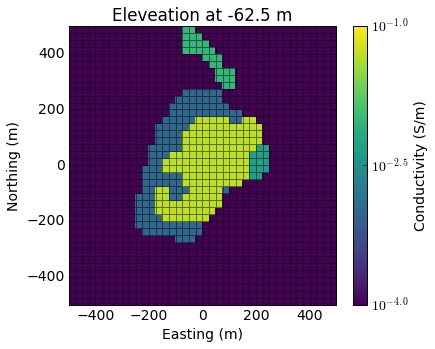

In [45]:
interact(lambda ind: viz(mesh, sigma, ind, airind=airind, normal="Z"), ind=IntSlider(min=0, max=32,step=1, value=28))

<function __main__.<lambda>>

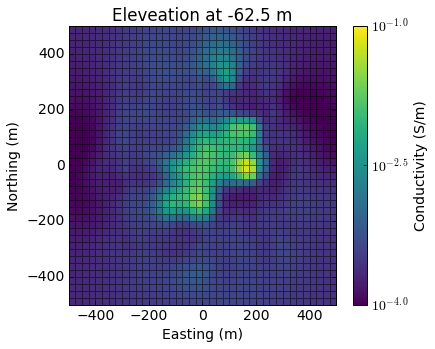

In [46]:
interact(lambda ind: viz(mesh, sigopt, ind, airind=airind, normal="Z"), ind=IntSlider(min=0, max=32,step=1, value=28))

<function __main__.<lambda>>

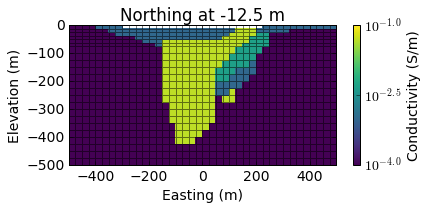

In [47]:
interact(lambda ind: viz(mesh, sigma, ind, airind=airind, normal="Y"), ind=IntSlider(min=0, max=32,step=1, value=30))

<function __main__.<lambda>>

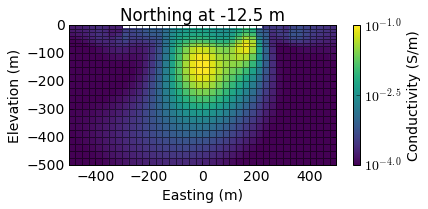

In [48]:
interact(lambda ind: viz(mesh, sigopt, ind, airind=airind,  normal="Y"), ind=IntSlider(min=0, max=32,step=1, value=30))

In [49]:
# vizdata(obsdata, src1, rx_x, rxcomponent="X", title="Ix and Vx")

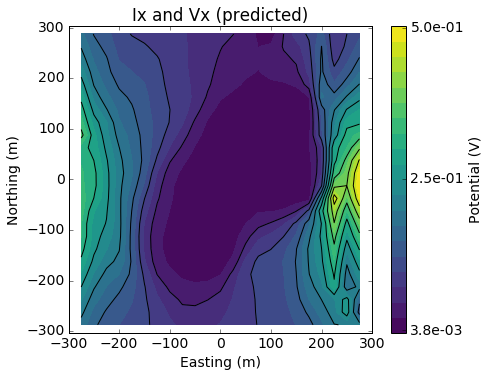

In [50]:
vizdata(preddata, src1, rx_x, rxcomponent="X", title="Ix and Vx (predicted)", figsave="./images/IxVx_pred.png")

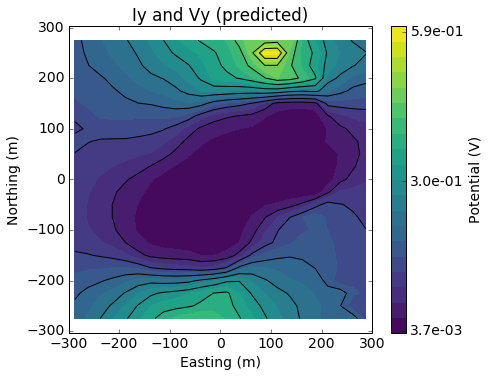

In [51]:
vizdata(preddata, src3, rx_y, rxcomponent="Y", title="Iy and Vy (predicted)", figsave="./images/IyVy_pred.png")

In [52]:
import pickle
Results = {"model_true":sigma, "model_pred":sigopt, "Obs":dobs, "Pred":dpred}
outputs = open("DCresults", 'wb')
pickle.dump(Results, outputs)
outputs.close()